<a href="https://colab.research.google.com/github/KaviyaKannan14/Data-Engineering-ML-projects/blob/main/Sentiment_Analysis_of_Energy_Crude_Oil_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#installing contractions library
!pip -q install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.6 MB/s eta 0:00:00


In [10]:
#Generic Data Processing & Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re,string,unicodedata
import contractions #import contractions_dict
from bs4 import BeautifulSoup
%matplotlib inline


#Importing text processing libraries
import spacy
import spacy.cli
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#downloading wordnet/punkt dictionary
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#Loading Dataset
url = '../input/sentiment-analysis-in-energy-crude-oil/tweets.csv'
raw_data = pd.read_csv("/content/tweets.csv")

In [12]:
raw_data.shape

(1000, 16)

In [13]:
#Creating a seperate dataset with specific columns.
data = raw_data[['text','screenName','retweetCount']]

In [14]:
#Resetting Index
data.reset_index(drop=True, inplace=True)

In [15]:
#Backup of the newly created dataset
data_backup = data.copy()

Text Cleaning

In [16]:
#lowering cases
data['text'] = data['text'].str.lower()

#stripping leading spaces (if any)
data['text'] = data['text'].str.strip()

In [17]:
# Removing HTML tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

#apply to the dataset
data['text'] = data['text'].apply(strip_html_tags)


In [18]:
# Remove URL and links
def strip_url(text):
    strip_url_text = re.sub(r'http\S+', '', text)
    return strip_url_text

#Applying the dataset
data['text'] = data['text'].apply(strip_url)


In [19]:
#removing punctuations
from string import punctuation

def remove_punct(text):
  for punctuations in punctuation:
    text = text.replace(punctuations, '')
  return text

#apply to the dataset
data['text'] = data['text'].apply(remove_punct)

In [20]:
#function to remove special characters
def remove_special_chars(text, remove_digits=True):
  pattern = r'[^a-zA-z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

#applying the function on the clean dataset
data['text'] = data['text'].apply(remove_special_chars)

In [21]:
#function to remove macrons & accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#applying the function on the clean dataset
data['text'] = data['text'].apply(remove_accented_chars)


In [22]:
#Function to expand contractions
def expand_contractions(con_text):
  con_text = contractions.fix(con_text)
  return con_text

#applying the function on the clean dataset
data['text'] = data['text'].apply(expand_contractions)


In [23]:
 #creating a new column in the dataset for word count
data ['word_count'] = data['text'].apply(lambda x:len(str(x).split(" ")))

#Taking Backup
data_clean = data.copy()

Text Preprocessing & Normalisation

In [24]:
#function to remove stopwords
def remove_stopwords(text, is_lower_case=False):
    stopword_list = set(stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#applying the function
data ['text'] = data['text'].apply(remove_stopwords)

Stemming

In [25]:
#Function for stemming
def simple_stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

#applying the function
data['Stemd_text'] = data['text'].apply(simple_stemmer)


In [26]:
#rearranging columns
data = data[['screenName','text','Stemd_text','retweetCount','word_count']]
#Taking Backup
data_preproc = data.copy()

Sentiment Analysis - TextBlob Library

In [27]:
#Import Textblob Library
from textblob import TextBlob

In [28]:
#function to perform Textblob Sentiment Analyis
def sentiment_analysis(text):
    polarity = round(TextBlob(text).sentiment.polarity, 3)
    sentiment_categories = ['positive','negative','neutral']
    if polarity > 0:
        return sentiment_categories[0]
    elif polarity < 0:
        return sentiment_categories[1]
    else:
        return sentiment_categories[2]

#Apply to the Stemd_Text
data['Sentiments'] = [sentiment_analysis(txt) for txt in data['Stemd_text']]

Analysis & Visualisation


`Distribution of Word Count`


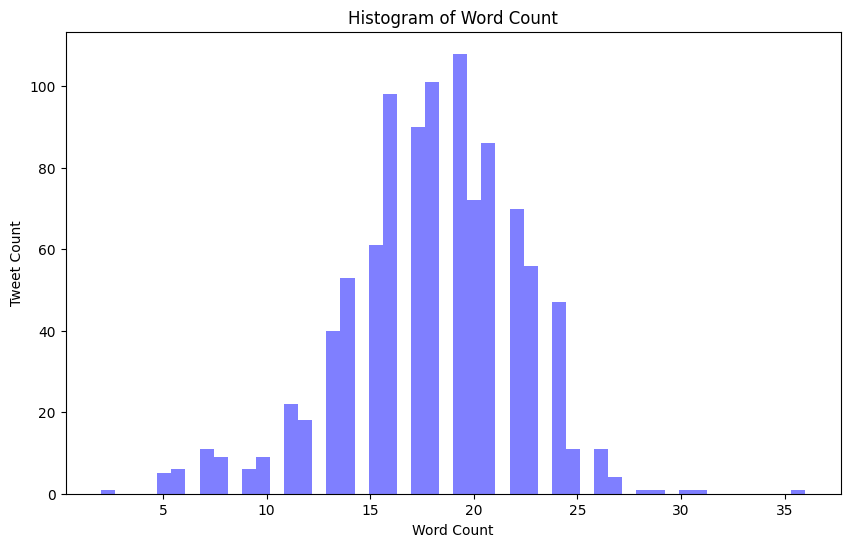

In [29]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data.word_count, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Tweet Count')
plt.title('Histogram of Word Count')
plt.show();

Analysis: A majority of tweets are between 15 - 20 words long

Text(0.5, 0, 'Sentiments')

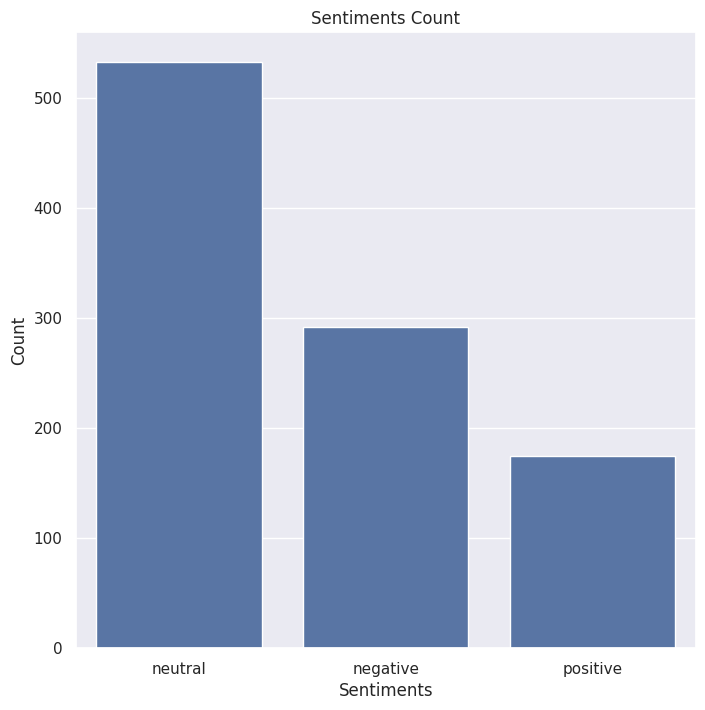

In [30]:
#Creating a Count Plot
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x="Sentiments", data=data)
plt.title('Sentiments Count')
plt.ylabel('Count')
plt.xlabel('Sentiments')

Analysis: Majority of the tweets are netural with 'negative' tweets being the second highest

In [31]:
data.head()

,screenName,text,Stemd_text,retweetCount,word_count,Sentiments
0,ArgusMedia,domestic output exceeding regional demand us c...,domest output exceed region demand us crudeoil...,0,17,neutral
1,macrohedged,friday us crude oil front 12 months futures pr...,friday us crude oil front 12 month futur price...,0,24,negative
2,El_Spy,rt aeberman12 opec pumped 296 mmbpd last month...,rt aeberman12 opec pump 296 mmbpd last month 1...,1,22,neutral
3,SuperiorMar,rt aeberman12 ships vanishing tracking screens...,rt aeberman12 ship vanish track screen clandes...,1,18,negative
4,aeberman12,opec pumped 296 mmbpd last month 170 kbd mays ...,opec pump 296 mmbpd last month 170 kbd may rev...,1,20,neutral


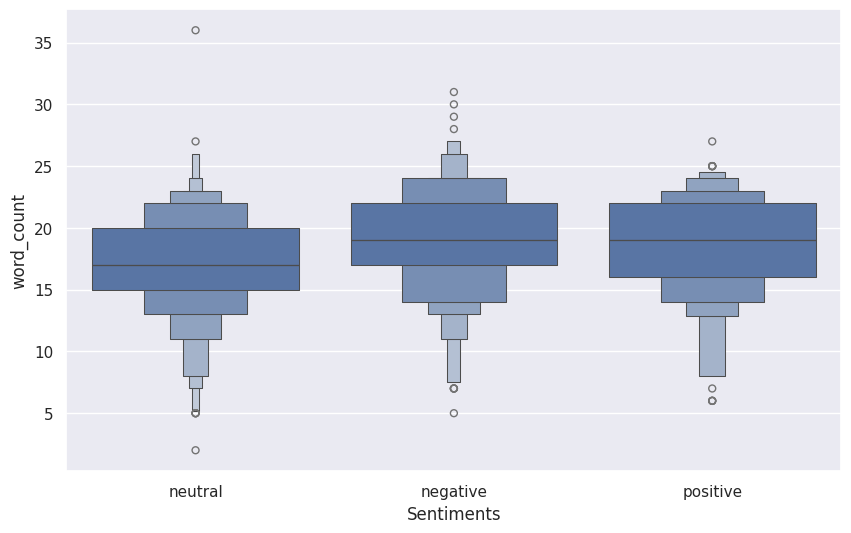

In [32]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='Sentiments', y='word_count', data=data)
plt.show();

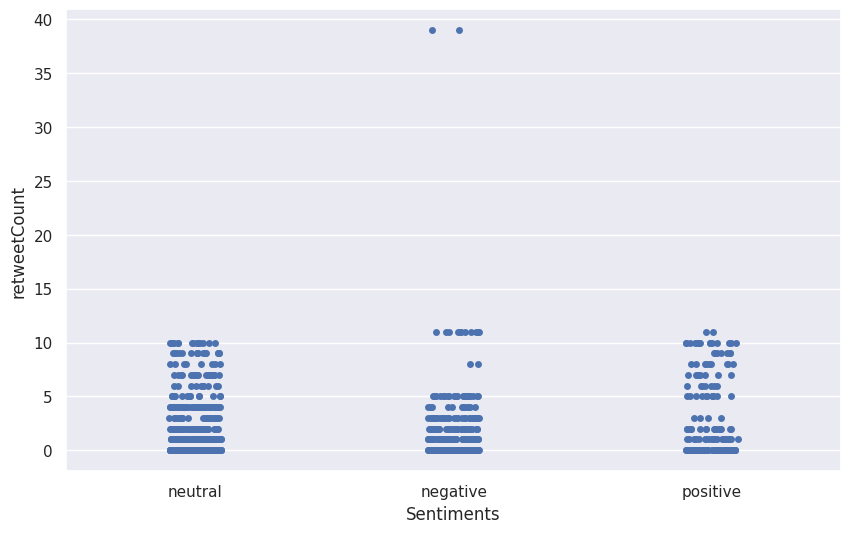

In [33]:
plt.figure(figsize=(10,6))
sns.stripplot(x='Sentiments', y='retweetCount', data=data)
plt.show();

Who are the users who had negative sentiments & a high retweet count ?

In [34]:
data[(data.Sentiments == 'negative') & (data.retweetCount > 35)]

,screenName,text,Stemd_text,retweetCount,word_count,Sentiments
496,DirtnRockguy62,rt aeberman12 industry claims breakeven prices...,rt aeberman12 industri claim breakeven price 4...,39,21,negative
736,samviskovic,rt aeberman12 industry claims breakeven prices...,rt aeberman12 industri claim breakeven price 4...,39,21,negative
